# Module Import

In [1]:
import pandas as pd
import numpy as np
import openpyxl

# import statsmodels.formula.api as smf

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# pandas 경고 무시
pd.set_option('mode.chained_assignment',  None)

from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# Data Load

In [2]:
data = pd.read_csv('../data/행정자치부 공공데이터 숙박업 등록현황.csv', encoding = 'cp949')
# 데이터 출처 : 공공데이터포털 / 행정안전부_숙박업 데이터
# https://www.data.go.kr/data/15044968/fileData.do
print(data.shape)
data.head()

(54051, 51)


,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,조건부허가시작일자,조건부허가종료일자,건물소유구분명,세탁기수,여성종사자수,남성종사자수,회수건조수,침대수,다중이용업소여부,Unnamed: 50
0,1,숙박업,03_11_03_P,3620000,3620000-201-2005-00005,20050818,NaN,1,영업/정상,1,...,NaN,NaN,임대,0.0,NaN,NaN,0.0,0.0,N,NaN
1,2,숙박업,03_11_03_P,3620000,3620000-201-2000-00013,20000615,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN
2,3,숙박업,03_11_03_P,3620000,3620000-214-1985-00002,19851119,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
3,4,숙박업,03_11_03_P,3620000,3620000-201-2000-00014,20000710,NaN,1,영업/정상,1,...,NaN,NaN,자가,0.0,NaN,NaN,0.0,0.0,N,NaN
4,5,숙박업,03_11_03_P,3620000,3620000-201-2002-00007,20020429,NaN,1,영업/정상,1,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,N,NaN


# Data Preprocessing

In [3]:
# 영업중인 숙박시설만 추출
df = data[data['상세영업상태명']=="영업"]

# 필요한 열만 추출 
df = df[['사업장명','업태구분명', '인허가일자']]

# 인허가일자 중 연도만 추출
df['인허가일자'] = df['인허가일자'].apply(lambda x: str(x)[:4])
df['인허가일자'] = df['인허가일자'].astype(int)

# 2022년 데이터 제거
df = df[df['인허가일자']<2022]

df = df.rename(columns={'사업장명':'name', '업태구분명':'type', '인허가일자':'year'})

In [4]:
# 숙박업 유형 변경
def hoteltype(x):
    if x == '숙박업(생활)':
        return '생활형숙박시설'
    else:
        return '일반숙박시설'

In [5]:
df['type'] = df['type'].apply(hoteltype)
df.head()

,name,type,year
0,야자,일반숙박시설,2005
1,엔(N)모텔,일반숙박시설,2000
2,디오앤에스임동,생활형숙박시설,1985
3,에로스모텔,일반숙박시설,2000
4,클라우드인호텔,일반숙박시설,2002


In [6]:
# 일반숙박시설과 생활형숙박시설 분리

df_normal = df[df['type']=='일반숙박시설']
df_residence = df[df['type']=='생활형숙박시설']
display(df_normal.head())
display(df_residence.head())

#2010년 이후 데이터만 추출
after2010 = df[df['year']>=2010]
after2010_normal = after2010[after2010['type']=='일반숙박시설']
after2010_residence = after2010[after2010['type']=='생활형숙박시설']

,name,type,year
0,야자,일반숙박시설,2005
1,엔(N)모텔,일반숙박시설,2000
3,에로스모텔,일반숙박시설,2000
4,클라우드인호텔,일반숙박시설,2002
5,다빈치모텔,일반숙박시설,2000


,name,type,year
2,디오앤에스임동,생활형숙박시설,1985
12,실크로드,생활형숙박시설,1985
299,경주게스트하우스,생활형숙박시설,1995
329,씨엘미니호텔,생활형숙박시설,1989
330,청춘게스트하우스 호스텔,생활형숙박시설,2017


# Time-Series

### fbprophet

- normal

In [10]:
normal = df_normal.groupby('year')[['type']].count().reset_index()
normal.rename(columns={'type':'count'}, inplace=True)
normal['type'] = '일반숙박시설'
normal['cumsum'] = normal['count'].cumsum()
normal = normal[['year', 'type', 'count', 'cumsum']]

normal_ts = pd.DataFrame({'ds':normal['year'], 'y':normal['count']})
normal_ts['ds'] = normal_ts['ds'].astype(str)
normal_ts['ds'] = pd.to_datetime(normal_ts['ds'])
normal_ts.head()

,ds,y
0,1900-01-01,1
1,1924-01-01,1
2,1957-01-01,1
3,1958-01-01,1
4,1959-01-01,1


In [11]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=False,
                 daily_seasonality=False,
                 changepoint_prior_scale=0.5)

prophet.fit(normal_ts)


C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [12]:
future_data = prophet.make_future_dataframe(periods = 5, freq = 'y')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
67,2021-12-31,461.761840,306.608263,625.869344
68,2022-12-31,468.091513,238.873706,667.530233
69,2023-12-31,474.069306,129.550209,771.825053
70,2024-12-31,482.884745,-86.003059,998.534662
71,2025-12-31,489.535855,-358.049389,1238.663003


C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


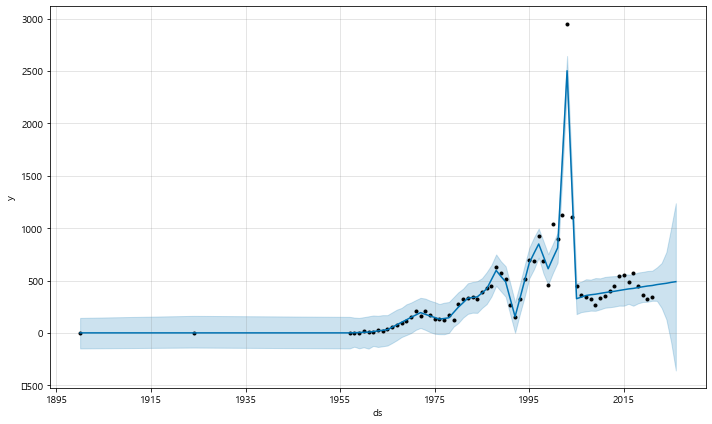

In [13]:
fig1 = prophet.plot(forecast_data)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


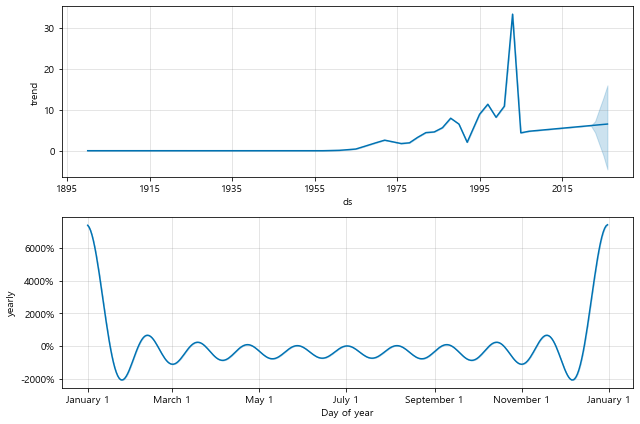

In [14]:
fig2 = prophet.plot_components(forecast_data)

In [46]:
x = np.arange(2010,2026)
y_normal = list(after2010_normal.groupby('year')['type'].count()[:11])
y_normal.extend(list(round(forecast_data['yhat'][-5:])))

lst_normal = pd.DataFrame({'year':x, 'count':y_normal})
lst_normal['cumsum'] = lst_normal['count'].cumsum()
lst_normal['type'] = '일반숙박시설'
lst_normal = lst_normal[['year','type','count','cumsum']]
lst_normal

,year,type,count,cumsum
0,2010,일반숙박시설,336.0,336.0
1,2011,일반숙박시설,350.0,686.0
2,2012,일반숙박시설,404.0,1090.0
3,2013,일반숙박시설,450.0,1540.0
4,2014,일반숙박시설,539.0,2079.0
5,2015,일반숙박시설,550.0,2629.0
6,2016,일반숙박시설,485.0,3114.0
7,2017,일반숙박시설,571.0,3685.0
8,2018,일반숙박시설,447.0,4132.0
9,2019,일반숙박시설,365.0,4497.0


- residence

In [52]:
residence = df_residence.groupby('year')[['type']].count().reset_index()
residence.rename(columns={'type':'count'}, inplace=True)
residence['type'] = '생활형숙박시설'
residence['cumsum'] = residence['count'].cumsum()
residence = residence[['year', 'type', 'count', 'cumsum']]

residence_ts = pd.DataFrame({'ds':residence['year'], 'y':residence['count']})
residence_ts['ds'] = residence_ts['ds'].astype(str)
residence_ts['ds'] = pd.to_datetime(residence_ts['ds'])
residence_ts.head()


,ds,y
0,1970-01-01,2
1,1971-01-01,4
2,1972-01-01,2
3,1973-01-01,2
4,1974-01-01,6


In [53]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(residence_ts)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [54]:
future_data = prophet.make_future_dataframe(periods = 5, freq = 'y')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
52,2021-12-31,667.570097,652.935664,682.911703
53,2022-12-31,323.787949,307.200386,340.421950
54,2023-12-31,729.688638,694.578471,766.181882
55,2024-12-31,645.820340,597.418027,691.147166
56,2025-12-31,675.789334,606.967135,742.898146


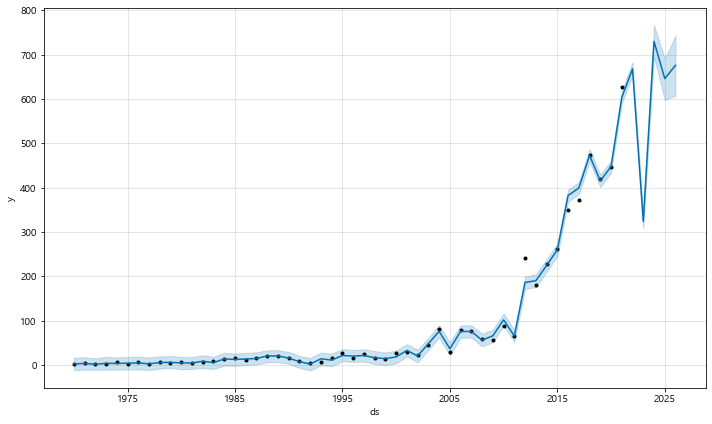

In [55]:
fig1 = prophet.plot(forecast_data)

C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\zyunhyeok\anaconda3\envs\prophet\lib\site-packages\fbprophet\forecaster.py:89

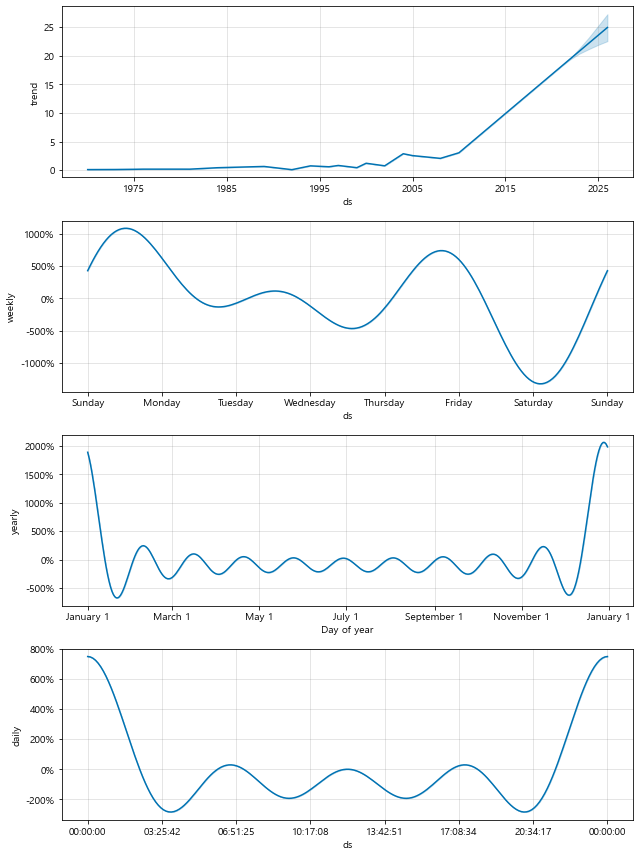

In [56]:
fig2 = prophet.plot_components(forecast_data)

In [58]:
x = np.arange(2010,2026)
y_residence = list(after2010_residence.groupby('year')['type'].count()[:11])
y_residence.extend(list(round(forecast_data['yhat'][-5:])))

lst_residence = pd.DataFrame({'year':x, 'count':y_residence})
lst_residence['cumsum'] = lst_residence['count'].cumsum()
lst_residence['type'] = '생활형숙박시설'
lst_residence = lst_residence[['year','type','count','cumsum']]
lst_residence

,year,type,count,cumsum
0,2010,생활형숙박시설,88.0,88.0
1,2011,생활형숙박시설,65.0,153.0
2,2012,생활형숙박시설,242.0,395.0
3,2013,생활형숙박시설,180.0,575.0
4,2014,생활형숙박시설,228.0,803.0
5,2015,생활형숙박시설,261.0,1064.0
6,2016,생활형숙박시설,350.0,1414.0
7,2017,생활형숙박시설,373.0,1787.0
8,2018,생활형숙박시설,473.0,2260.0
9,2019,생활형숙박시설,419.0,2679.0


In [60]:
count_all = pd.concat([lst_normal, lst_residence])
count_all

,year,type,count,cumsum
0,2010,일반숙박시설,336.0,336.0
1,2011,일반숙박시설,350.0,686.0
2,2012,일반숙박시설,404.0,1090.0
3,2013,일반숙박시설,450.0,1540.0
4,2014,일반숙박시설,539.0,2079.0
5,2015,일반숙박시설,550.0,2629.0
6,2016,일반숙박시설,485.0,3114.0
7,2017,일반숙박시설,571.0,3685.0
8,2018,일반숙박시설,447.0,4132.0
9,2019,일반숙박시설,365.0,4497.0


# Data Visualization

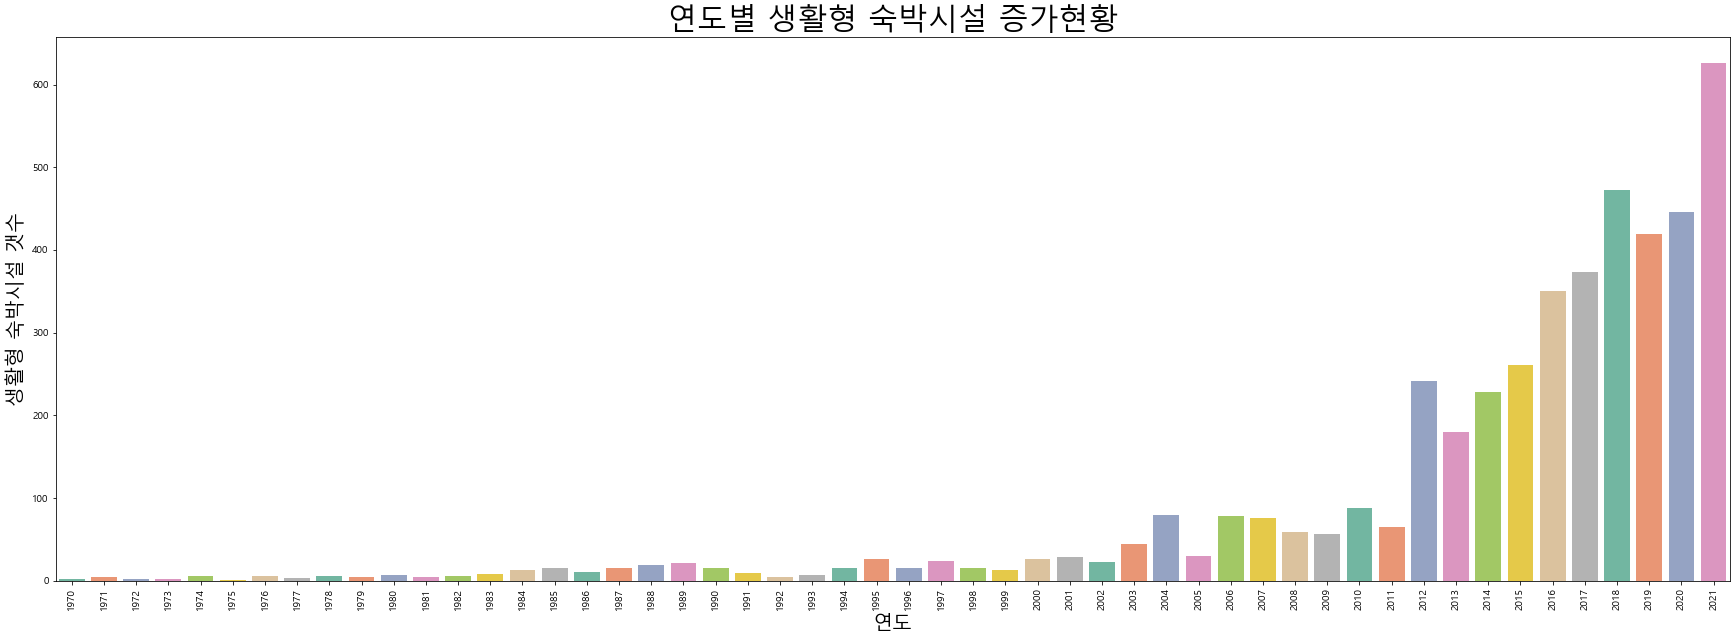

In [61]:
plt.figure(figsize=(30,10))
sns.countplot(x='year', data=df_residence, palette='Set2', order = sorted(df_residence['year'].unique()))
plt.title('연도별 생활형 숙박시설 증가현황', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('생활형 숙박시설 갯수', fontsize=20)
plt.xticks(rotation=90)
plt.show()

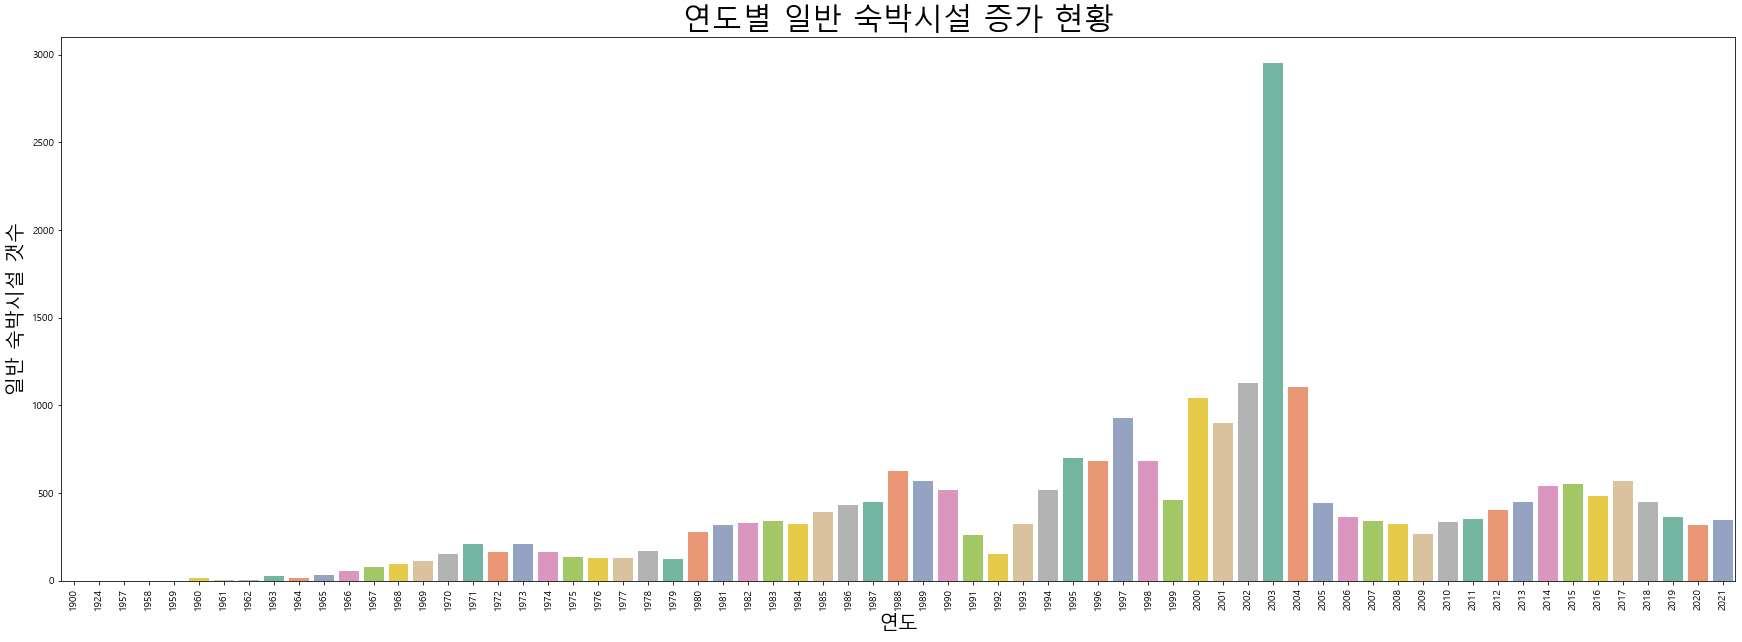

In [62]:
plt.figure(figsize=(30,10))
sns.countplot(x='year', data=df_normal, palette='Set2', order = sorted(df_normal['year'].unique()))
plt.title('연도별 일반 숙박시설 증가 현황', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('일반 숙박시설 갯수', fontsize=20)
plt.xticks(rotation=90)
plt.show()

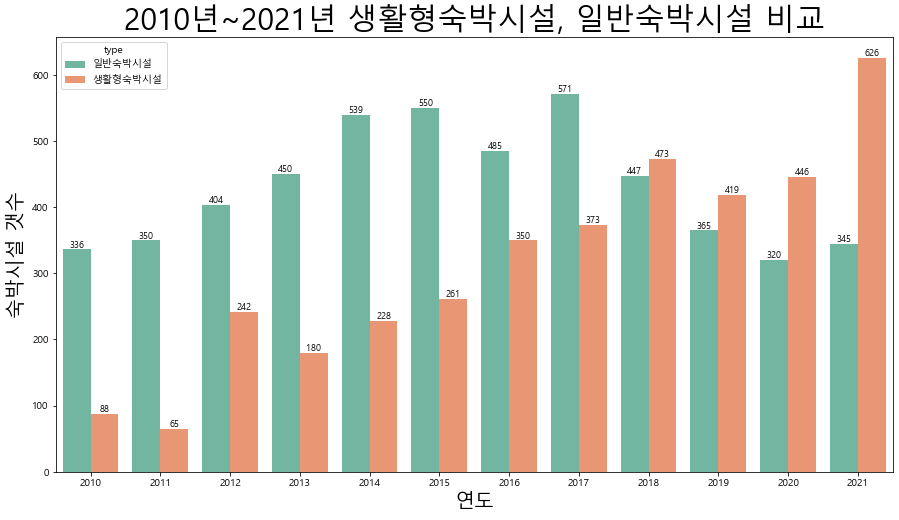

In [63]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='year', data=after2010, palette='Set2', hue="type", dodge = True, order = sorted(after2010['year'].unique()))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
    
plt.title('2010년~2021년 생활형숙박시설, 일반숙박시설 비교', fontsize=30)
plt.xlabel('연도', fontsize=20)
plt.ylabel('숙박시설 갯수', fontsize=20)
# plt.xticks(rotation=90)
plt.show()

# Prediction Visualization

In [66]:
parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(parameters)

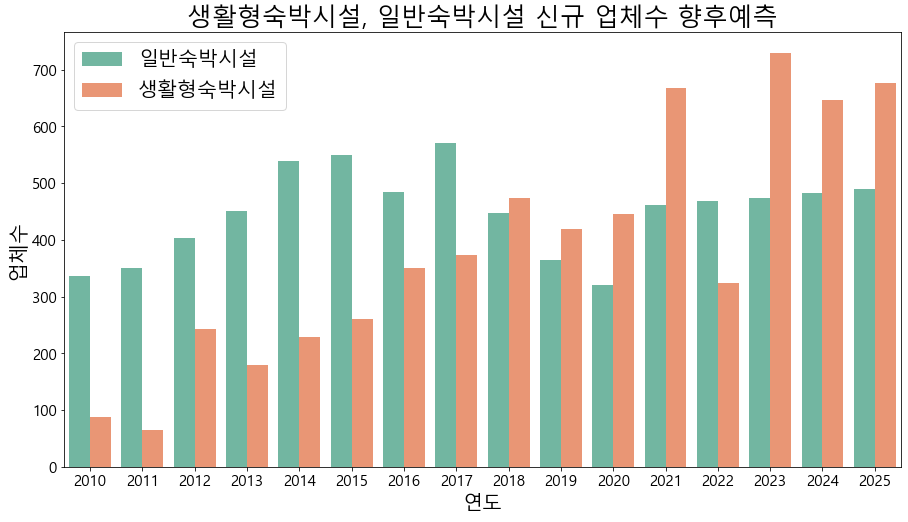

In [67]:
plt.figure(figsize=(15,8))
sns.barplot(data=count_all, x="year", y="count", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 신규 업체수 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('업체수', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()

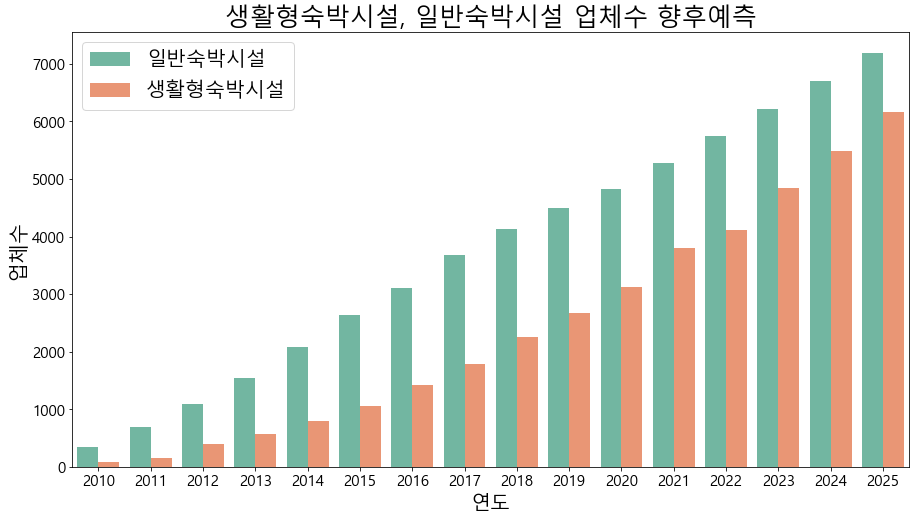

In [68]:
plt.figure(figsize=(15,8))
sns.barplot(data=count_all, x="year", y="cumsum", hue="type", palette='Set2')

plt.title('생활형숙박시설, 일반숙박시설 업체수 향후예측', fontsize=25)
plt.xlabel('연도', fontsize=20)
plt.ylabel('업체수', fontsize=20)
plt.legend(fontsize=20, loc = 'best')
plt.show()